In [1]:
# Nos conectamos a nuestro conjunto de datos

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras import optimizers, Model
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import VGG16
import locale
import matplotlib.gridspec as gridspec
from tensorflow.keras.layers import Input, concatenate

# optimizador de la red por medio de Bayessian Optimization
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Abrimos todos nuestros datos

# ./drive/MyDrive/deep-learning-rogelio/train_data.csv
df_train = pd.read_csv('./drive/MyDrive/deep-learning-rogelio/train_data.csv', sep=';', decimal='.')
print(df_train.shape)

df_test = pd.read_csv('./drive/MyDrive/deep-learning-rogelio/test_data.csv', sep=';', decimal='.')
print(df_test.shape)

# Vamos a abrir las imágenes
trainImagesX = np.load("./drive/MyDrive/deep-learning-rogelio/trainImagesX.npy")
print(trainImagesX.shape)

# Abrimos las imagenes de test
testImagesX = np.load("./drive/MyDrive/deep-learning-rogelio/testImagesX.npy")
print(testImagesX.shape)

x_train_images = trainImagesX / 255
x_test_images = testImagesX / 255

# Hacemos el split de train y validation para las imágenes y los atributos
# Lo hacemos con el dataframe completo, aún no separamos los valores

split = train_test_split(df_train, x_train_images, test_size=0.1, random_state=42)
(trainAttrX, valAttrX, trainImagesX, valImagesX) = split

# Separamos x_train, y_train y convertimos a numpy
x_train = trainAttrX.drop(['Price'], axis=1).values
y_train = trainAttrX['Price'].values

x_val = valAttrX.drop(['Price'], axis=1).values
y_val = valAttrX['Price'].values

# Separamos x_test, y_test y convertimos a numpy
x_test = df_test.drop(['Price'], axis=1).values
y_test = df_test['Price'].values

from sklearn.preprocessing import MinMaxScaler
# Create the scaler object
scaler = MinMaxScaler()

# Fit the scaler to the training data
scaler.fit(x_train)

# Transform the training and test data
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)


(750, 22)
(250, 22)
(750, 224, 224, 3)
(250, 224, 224, 3)


### Primer prueba, generar el modelo con las 2 arquiteccturas y entrenarlo conjuntamente

In [4]:
# Funciones para generar nuestros modelos

def generate_mlp(activation_function):
  
  # Implementamos la red empleando Keras
  model = Sequential() # Instancia de modelo API secuencial #(X)
  model.add(Dense(64, activation=activation_function, name='mlp_dense_1', input_shape=(x_train.shape[1],)))
  model.add(Dropout(0.2, name='mlp_dropout_1',))
  model.add(Dense(64, activation=activation_function, name='mlp_dense_2',))
  model.add(Dropout(0.2, name='mlp_dropout_2',))
  # lo hacmeos sin la ultima capa
  # model.add(Dense(1, activation='linear', name='mlp_dense_3',)) 
  return model

def generate_cnn():

  base_model_2 = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

  # Add a custom top to the model for regression
  """
  x = layers.Flatten()(base_model_2.output)
  x = layers.Dense(64, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(1, activation='linear')(x)
  """

  # add a global spatial average pooling layer
  x = base_model_2.output
  x = Dropout(.5)(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(.5)(x)
  # let's add a fully-connected layer
  x = Dense(1024, activation='selu')(x)
  x = Dropout(.5)(x)
  # and output layer
  # No le hacemos caso a nuestra ultima capa
  #predictions = Dense(1)(x)

  # Compile the model
  # model2 = models.Model(base_model_2.input, x)
  # this is the model we will train
  model2 = Model(inputs=base_model_2.input, outputs=x)

  # let's visualize layer names and layer indices to see how many layers
  # we should freeze:
  #for i, layer in enumerate(base_model_2.layers):
  #  print(i, layer.name)

  # we chose to train the top 2 inception blocks, i.e. we will freeze
  # the first 249 layers and unfreeze the rest:
  for layer in model2.layers[:16]:
    layer.trainable = False
  for layer in model2.layers[16:]:
    layer.trainable = True

  return model2

In [7]:
generated_mlp_model = generate_mlp('relu')
generated_cnn_model = generate_cnn()
# combinamos las salidas, estas son de x dimensiones
combinedInput = concatenate([generated_mlp_model.output, generated_cnn_model.output])
# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[generated_mlp_model.input, generated_cnn_model.input], outputs=x)

# Compile the combined model
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='mse', 
                       metrics=[
                  metrics.MeanAbsoluteError(), 
                  metrics.MeanSquaredError(), 
                  metrics.RootMeanSquaredError()])


# Define the callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    x=[x_train, trainImagesX], 
    y=y_train, 
    batch_size=128, 
    steps_per_epoch=10,
    epochs=50, 
    validation_data=([x_val, valImagesX], y_val), 
    callbacks=[early_stopping, reduce_lr], 
    verbose=1)

0 input_2
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
Epoch 1/50
10/10 [==============================] - 17s 329ms/step - loss: 6855.8140 - mean_absolute_error: 61.3725 - mean_squared_error: 6855.8140 - root_mean_squared_error: 82.7998 - val_loss: 4277.4985 - val_mean_absolute_error: 48.7154 - val_mean_squared_error: 4277.4985 - val_root_mean_squared_error: 65.4026 - lr: 1.0000e-04
Epoch 2/50
10/10 [==============================] - 1s 89ms/step - loss: 4707.1812 - mean_absolute_error: 41.3898 - mean_squared_error: 4707.1812 - root_mean_squared_error: 68.6089 - val_loss: 2074.9922 - val_mean_absolute_error: 36.2353 - val_mean_squared_error: 2074.9922 - val_root_mean_squared_error: 45.5521 - lr: 1.0000e-04
Epoch 3/50
10/10 [==============================] - 1s

8/8 [==============================] - 1s 83ms/step
Mean Squared Error (MSE): 1479.1808770381258
Mean Absolute Error (MAE): 25.47679997253418
R-squared (R^2): 0.09115464367455595
[INFO] avg. house price: $64.59, std house price: $55.36
[INFO] mean: 54.43%, std: 59.58%


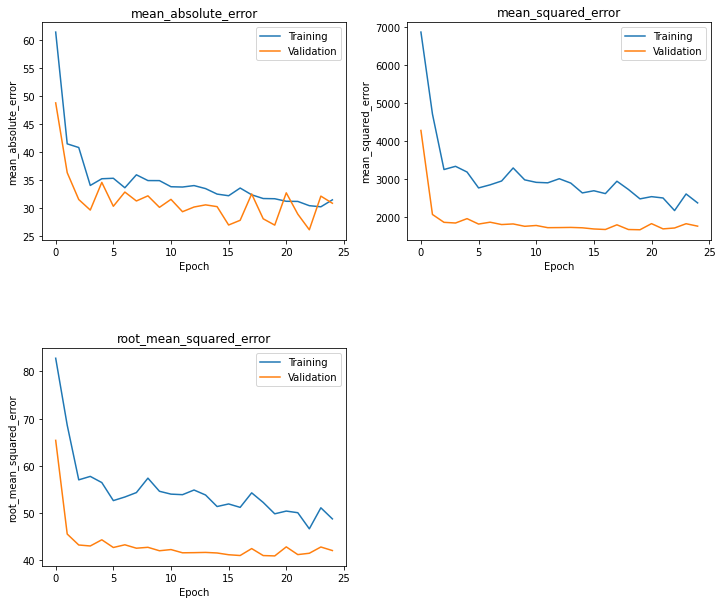

In [8]:
# Evaluate the model on the test set
test_pred = model.predict([x_test, x_test_images])
mse = mean_squared_error(y_test, test_pred)
mae = mean_absolute_error(y_test, test_pred)
r2 = r2_score(y_test, test_pred)

# Print the evaluation metrics
print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R^2):', r2)

diff = test_pred.flatten() - y_test
percentDiff = (diff / y_test) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
    locale.currency(df_train["Price"].mean(), grouping=True),
    locale.currency(df_train["Price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))
 # Create a grid of subplots that shares the y-axis across rows and the x-axis across columns
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(nrows=2, ncols=2, figure=fig, hspace=0.5, wspace=0.2, height_ratios=[1, 1])

# Plot the training and validation curves for each metric
for i, metric in enumerate(['mean_absolute_error', 'mean_squared_error', 'root_mean_squared_error']):
    row = i // 2
    col = i % 2
    ax = fig.add_subplot(gs[row, col])
    ax.plot(history.history[metric], label='Training')
    ax.plot(history.history['val_' + metric], label='Validation')
    ax.set_title(metric)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric)
    ax.legend(loc='upper right')
plt.show()

In [1]:
# Se ve prometedor, creo que buscando un poco mas en cuestión de los parámetros de la red, podriamos generar un mejor desempeño, los saltos que da la grafica reflejan que se puede modificar el learning rate, ya que está hciendo algunos saltos, de la misma forma se podrían generar mas capas

## Y si cargamos los modelos que habiamos guardado?

In [9]:
# Abrimos nuestros modelos entrenados

ann_model = keras.models.load_model('./drive/MyDrive/deep-learning-rogelio/model_ann_v1.h5')

cnn_model = keras.models.load_model('./drive/MyDrive/deep-learning-rogelio/transfer_l_v2.h5')

# removemos la ultima capa simplemente diciendole que la capa de salida es la penultima
ann_model = Model(inputs=ann_model.input, outputs=ann_model.layers[-2].output)

cnn_model = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-2].output)

# Hacemos que las capas no se reentreen
# set all layers in the MLP to non-trainable
for layer in ann_model.layers:
    layer.trainable = False
#ann_model.summary()

# set all layers in the CNN to non-trainable
for layer in cnn_model.layers:
    layer.trainable = False
#cnn_model.summary()



# Get the last layer of the CNN model
cnn_output = cnn_model.output

# Get the last layer of the ANN model
ann_output = ann_model.output

# Concatenate the outputs of the CNN and ANN models
combined = concatenate([cnn_output, ann_output])

## Como en el tutorial añadimos una salida
x = Dense(4, activation="relu")(combined)
x = Dense(1, activation="linear")(x)


# Define the combined model
combined_model = Model(inputs=[cnn_model.input, ann_model.input], outputs=x)

# de esta forma podremos entrenar las ultimas 2 que añadimos
#combined_model.summary()

ValueError: ignored

In [36]:
# Compile the combined model
combined_model.compile(optimizer='adam', loss='mse', 
                       metrics=[
                  metrics.MeanAbsoluteError(), 
                  metrics.MeanSquaredError(), 
                  metrics.RootMeanSquaredError()])


# Define the callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = combined_model.fit(
    x=[trainImagesX, x_train], 
    y=y_train, 
    batch_size=128, 
    epochs=50, 
    validation_data=([valImagesX, x_val], y_val), 
    callbacks=[early_stopping, reduce_lr], 
    verbose=1)

# Evaluate the model on the test set
test_pred = combined_model.predict([x_test_images, x_test])
mse = mean_squared_error(y_test, test_pred)
mae = mean_absolute_error(y_test, test_pred)
r2 = r2_score(y_test, test_pred)

# Print the evaluation metrics
print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R^2):', r2)

Epoch 1/50
6/6 [==============================] - 2s 182ms/step - loss: 2785.8818 - mean_absolute_error: 32.8742 - mean_squared_error: 2785.8818 - root_mean_squared_error: 52.7815 - val_loss: 1617.7418 - val_mean_absolute_error: 30.3687 - val_mean_squared_error: 1617.7418 - val_root_mean_squared_error: 40.2212 - lr: 0.0010
Epoch 2/50
6/6 [==============================] - 1s 99ms/step - loss: 2694.3074 - mean_absolute_error: 32.9379 - mean_squared_error: 2694.3074 - root_mean_squared_error: 51.9067 - val_loss: 1597.1787 - val_mean_absolute_error: 30.2451 - val_mean_squared_error: 1597.1787 - val_root_mean_squared_error: 39.9647 - lr: 0.0010
Epoch 3/50
6/6 [==============================] - 1s 97ms/step - loss: 2718.0203 - mean_absolute_error: 32.7211 - mean_squared_error: 2718.0203 - root_mean_squared_error: 52.1346 - val_loss: 1596.4038 - val_mean_absolute_error: 30.6202 - val_mean_squared_error: 1596.4038 - val_root_mean_squared_error: 39.9550 - lr: 0.0010
Epoch 4/50
6/6 [===========

[INFO] avg. house price: $64.59, std house price: $55.36
[INFO] mean: 34.97%, std: 35.88%


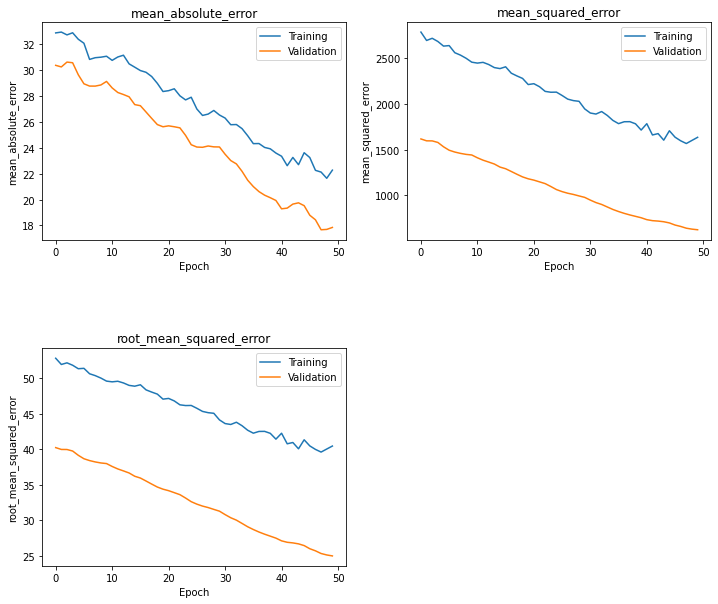

In [37]:
diff = test_pred.flatten() - y_test
percentDiff = (diff / y_test) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
    locale.currency(df_train["Price"].mean(), grouping=True),
    locale.currency(df_train["Price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))
 # Create a grid of subplots that shares the y-axis across rows and the x-axis across columns
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(nrows=2, ncols=2, figure=fig, hspace=0.5, wspace=0.2, height_ratios=[1, 1])

# Plot the training and validation curves for each metric
for i, metric in enumerate(['mean_absolute_error', 'mean_squared_error', 'root_mean_squared_error']):
    row = i // 2
    col = i % 2
    ax = fig.add_subplot(gs[row, col])
    ax.plot(history.history[metric], label='Training')
    ax.plot(history.history['val_' + metric], label='Validation')
    ax.set_title(metric)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric)
    ax.legend(loc='upper right')
plt.show()

In [2]:
# Al correrlo una segunda vez, se intentó usar los modelos anteriores guardados, solo que tenemos problemas con los nombres de las capas, de alguna manera funcionó, se observa que se puede mejorar el entrenamiento, añadiendo tal vez mas epocas y otros hiperparámetros, por el momento aqui nos quedamos